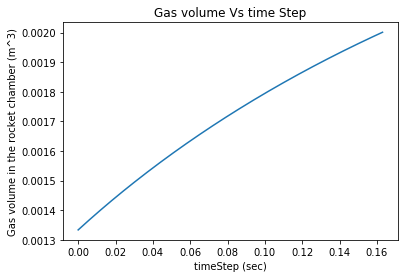

In [319]:
import numpy as np;
import matplotlib.pyplot as plt;

P_atm = 101325; # atomspheric pressure. Pa, absolute pressure
P_gage = 137895; #gage pressure of the air expanding, in Pa
P_GI = P_atm + P_gage; # Initial  absolute pressure of the gas in the rocket.Pa
V_LI = 1/3 * 2 * 0.001# volume of liquid in the rocket. m^3
rho_L = 1000; #density of liquid in bottle. 1000 kg/m^3
rho_air = 1.225; #density of air at stp, which we assume is the fluid in the external environment. 1.225kg/m^3



M_S = 0.042; # Structure mass of the rocket. 42 gram, so 0.042 kg, assume 2L bottle.
M_L = V_LI * rho_L; # Liquid mass in the ruclet.
M_G = 0.0035 # mass of air in the rocket that we measure, in gram
#from subtracting mass of liquid and structur mass from total mass of rocket.

M_R = M_L + M_S + M_G; #Total mass of the rocket.
# M_L + M_S = M_R assume gas mass is negligible.

A_1 = np.pi * np.power(104 * 0.001 / 2, 2); # Average area for the bottle rocket, 2L bottle, 104mm diameter
A_2 = np.pi * np.power(21 * 0.001 / 2, 2); # Area of Rocket nozzle, 2Lbottle, 21mm diameter
V_R = 2 * 0.001; #total volume of rocket chamber. m^3
c_d = 0.42; #drag coefficient of the bottle. We model it as a semi-sphere.
V_GI = V_R - V_LI;

g = 9.81; #gravitational constant.
R = 8.3145; #idea gas constant, in J mol^-1 K^-1

Molar_Gas = 28.97; #molar mass of gas filled in the rocket. in g /mol.
c_P = 1000; #Isobaric specific heat of gas, air, assume room temperatur; J * K/kg
c_V = 718; #Isochoric specific heat of gas, air, assume room temperature; J * K /kg
Gamma = c_P / c_V;

dt = 0.001; #time step we use during analysis for euler's method.

#Now we begin evaluating volume expansion of gas in the rocket.

volume_Gas = [];
volume_Gas.append(V_GI);
timeStep_gasVolume = [];
timeStep_gasVolume.append(0);

volume_rateOfChange_array = [];

counter = 0;
while (volume_Gas[counter] <= V_R):
    A = 2 * (P_GI * (np.power(V_GI / volume_Gas[counter], Gamma)) - P_atm);
    B = rho_L * (1 - np.power(A_2 / A_1, 2));
    volume_rateOfChange = A_2 * np.sqrt(A / B);
    volume_rateOfChange_array.append(volume_rateOfChange);
    
    volume_Next = volume_Gas[counter] + volume_rateOfChange * dt;
    volume_Gas.append(volume_Next);
    timeStep_gasVolume.append(timeStep_gasVolume[counter] + dt);
    counter = counter + 1;

volume_Gas = np.array(volume_Gas);
timeStep_gasVolume = np.array(timeStep_gasVolume);
plt.xlabel("timeStep (sec)");
plt.ylabel("Gas volume in the rocket chamber (m^3)");
plt.title("Gas volume Vs time Step");
plt.plot(timeStep_gasVolume, volume_Gas);

volume_rateOfChange_array = np.array(volume_rateOfChange_array);
#print(volume_rateOfChange_array)

# Now we know how gas volume changes in the rocket with respect to time

# note we have a warning below, because size of array for rate of change is one less than that for the changing quantity.
# I made the code such that it will not undermine overall estimation.
# but this is an inevitable problem using euler's method, which we would have to tackle for more rigorous analysis.


164


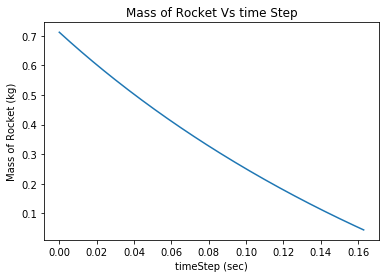

In [320]:
# now we evaluate how mass of rocket changed as gas volume expands.
timeOfiteration = np.size(volume_Gas);
print(timeOfiteration);

M_R_array = [];
M_R_array.append(M_R);
timeStep_rocketMass = [];
timeStep_rocketMass.append(0);

for i in range(0, timeOfiteration - 1):
    
    volume_rateOfChange = volume_rateOfChange_array[i];
    M_R_next = M_R_array[i] - rho_L * volume_rateOfChange * dt;
    #print(volume_rateOfChange);
    
    M_R_array.append(M_R_next);
    timeStep_rocketMass.append(timeStep_rocketMass[i] + dt);

M_R_array = np.array(M_R_array);
timeStep_rocketMass = np.array(timeStep_rocketMass);

#print(M_R_array);
#print(M_R_array)
plt.xlabel("timeStep (sec)");
plt.ylabel("Mass of Rocket (kg)");
plt.title("Mass of Rocket Vs time Step");
plt.plot(timeStep_rocketMass, M_R_array);
    
    
    

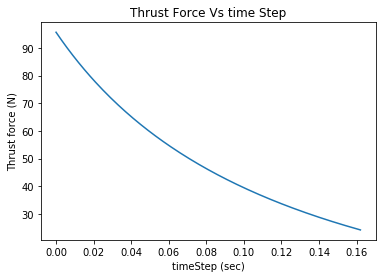

In [321]:
# Now we evalute thrust force as a function of time.
# note that when volume of gas is equal to the bottle volume, we have a discontinuity that the thrust force would be zero as
# water has been fully evaculated from the chamber and we assume gas mass is negligible and thus does not create any thrust.
# note that in actual liquid rocket, there would be a sudden "explosion" on gas due to water evaluated fully,
# but such sudden explosion would be very hard to evaluate given mathmatical tools we have...Modeling unexpected
# and unpredicatble turbulance has always been hard.
timeOfiteration = np.size(volume_Gas);
F_T_array = [];
timeStep_thrustForce = [];
for i in range(0, timeOfiteration - 1):
    volume_gas_instant = volume_Gas[i];
    A = 2 * A_2 * (P_GI * (np.power(V_GI / volume_gas_instant, Gamma)) - P_atm);
    B = 1 - np.power(A_2 / A_1, 2);
    F_T_instant = A / B;
    F_T_array.append(F_T_instant);
    timeStep_thrustForce.append(i * dt);

F_T_array = np.array(F_T_array);
timeStep_thrustForce = np.array(timeStep_thrustForce);

#print(M_R_array);
#print(M_R_array)
plt.xlabel("timeStep (sec)");
plt.ylabel("Thrust force (N)");
plt.title("Thrust Force Vs time Step");
plt.plot(timeStep_thrustForce, F_T_array);

#print(F_T_array);
    

(3850,)
(3850,)
(3850,)
(3850,)
[124.54317343 124.23229273 123.93225527 ...  -1.6740845   -1.67190593
  -1.66972991]


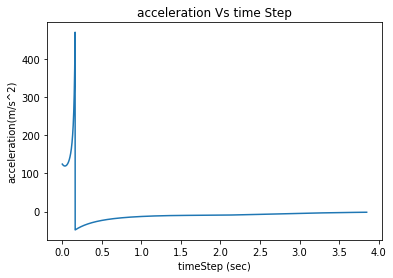

In [322]:
# Now we begin our kinematic analysis, where we will find acceleration, velocity, and vertical displacement of the rocket as
# a function of time.
# the tricky part is that acceleration and velocity are interdependent because drag force depends on velocity and acceleration
# depends on the drag force, so we will update all three quantity simultaneously using first order Tarlor expansion.


acceleration_array = [];

velocity_array = [];
velocity_array.append(0);

displacement_array = [];
displacement_array.append(0);

newDisplacement = 0;



timeStep_array = [];
timeStep_array.append(0);

#note I set iteration time to be two less than size of volume_gas array because of same issue we had in code block one.
# that at terminal point for equations, array that contains rate of change will be one less then array for changing quantity.
# however, since the time step is small, we still yield good accuracy. so this model still works
# we use size of thrust force array as a terminal point where thrust force becomes zero as liquid
# drains out. (we assume air does not generate thrust due to its small mass.)
counter = 0;

while(newDisplacement >= 0):
    if (counter < np.size(F_T_array)):
        F_thrust = F_T_array[counter]; #access thrust force at a given point that we obtained from previous part.
        F_drag = 0.5 * A_1 * c_d * rho_air * np.power(velocity_array[counter], 2); # the drag force applied at a given point.
        F_w = M_R_array[counter] * g; # weight of the rocket at a given point.
        
        acceleration_instant = (F_thrust - F_drag - F_w) / M_R_array[counter];
        
        if (velocity_array[counter] < 0):
            acceleration_instant = (-F_thrust + F_drag - F_w) / M_R;
            
        velocity_instant = velocity_array[counter] + acceleration_instant * dt;
        displacement_instant = displacement_array[counter] + velocity_instant * dt;
        
        newDisplacement = displacement_instant;
        #print(newDisplacement);
        
        acceleration_array.append(acceleration_instant);
        velocity_array.append(velocity_instant);
        displacement_array.append(displacement_instant);
        
        timeStep_array.append(timeStep_array[counter] + dt);
        
        counter = counter + 1;
    else:
        #print("enter else");
        F_thrust = 0; #as we are out of bound of the F_thrust array.
        M_R = M_S; # rocket mass is a constant, which is about structure mass or rocket. We ignore mass of gas for simplicity
        F_drag = 0.5 * A_1 * c_d * rho_air * np.power(velocity_array[counter], 2); # the drag force applied at a given point.
        F_w = M_R * g; # weight of the rocket at a given point.
        acceleration_instant = (F_thrust - F_drag - F_w) / M_R;
        
        if (velocity_array[counter] < 0):
            acceleration_instant = (-F_thrust + F_drag - F_w) / M_R;
            
        velocity_instant = velocity_array[counter] + acceleration_instant * dt;
        displacement_instant = displacement_array[counter] + velocity_instant * dt;
        #print("displacement before enter else is" + str(displacement_array[counter]));
        #print("change in displacement is" + str(velocity_instant * dt));
        #print("newDisplacement instant is " + str(displacement_instant));
        
        newDisplacement = displacement_instant;
        #print(newDisplacement);
        
        acceleration_array.append(acceleration_instant);
        velocity_array.append(velocity_instant);
        displacement_array.append(displacement_instant);
        
        timeStep_array.append(timeStep_array[counter] + dt);
        
        counter = counter + 1;
        


        
acceleration_array = np.array(acceleration_array);
velocity_array = np.array(velocity_array);
displacement_array = np.array(displacement_array);
timeStep_array = np.array(timeStep_array);



unifiedSize = int(min([np.size(acceleration_array), np.size(velocity_array), np.size(displacement_array), np.size(timeStep_array)]));

acceleration_array = acceleration_array[:unifiedSize];
velocity_array = velocity_array[:unifiedSize];
displacement_array = displacement_array[:unifiedSize];
timeStep_array = timeStep_array[:unifiedSize];

print(np.shape(acceleration_array));
print(np.shape(velocity_array));
print(np.shape(displacement_array));
print(np.shape(timeStep_array));

#print(displacement_array)

plt.xlabel("timeStep (sec)");
plt.ylabel("acceleration(m/s^2)");
plt.title("acceleration Vs time Step");
plt.plot(timeStep_array, acceleration_array); 
print(acceleration_array)

        



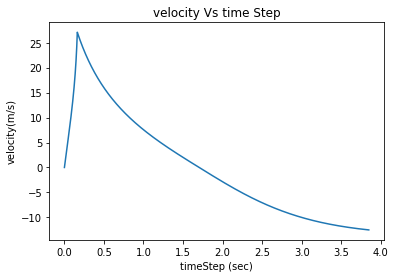

In [323]:
plt.xlabel("timeStep (sec)");
plt.ylabel("velocity(m/s)");
plt.title("velocity Vs time Step");
plt.plot(timeStep_array, velocity_array); 

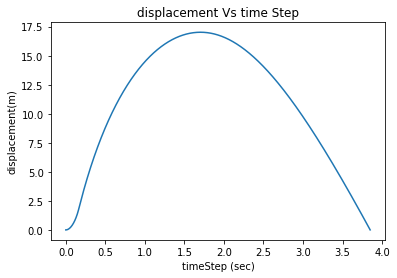

In [329]:
plt.xlabel("timeStep (sec)");
plt.ylabel("displacement(m)");
plt.title("displacement Vs time Step");
plt.plot(timeStep_array, displacement_array);

In [330]:
# Now we have full kinematic equations. 
# this tells us about launching velocity of the rocket, which is very helpful.


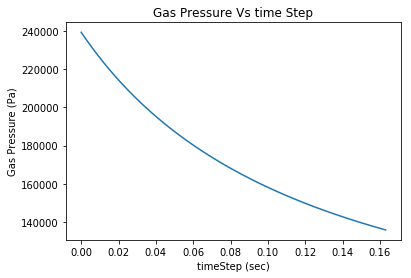

In [331]:
# Now we have full kinematic equation of rocket, now let we explor temperature change of gas in the rocket. In an actual liquid
# rocket, we will se mist formed in the chamber due to gas expansion. Although we did not take this into account in kinematic
# modeling, we can still play a bit with that interesting phenomenon. We can also use it as another way to derive thrust force 
# expression

# consider idea gas equation:
#                           PV = nRT
# Where P is absolute pressure in Pa, V is volume in m^3, n is number of mole. R is ideal gas constant, T is 
# temperature in Kelvin.

# we first calculate pressure of air
Air_pressure_array = P_GI * np.power(V_GI / volume_Gas, Gamma);
plt.xlabel("timeStep (sec)");
plt.ylabel("Gas Pressure (Pa)");
plt.title("Gas Pressure Vs time Step");
plt.plot(timeStep_gasVolume, Air_pressure_array);






317.52690910028093


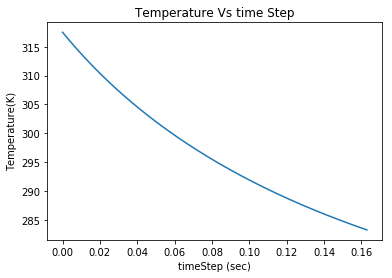

In [332]:
T_initial = P_GI * V_GI * Molar_Gas / (R * M_G * 1000);

print(T_initial);
T_array = [];
T_array.append(T_initial);

for i in range(0, np.size(Air_pressure_array) - 1):
    T_new = T_array[i] + Air_pressure_array[i] * (volume_Gas[i] - volume_Gas[i + 1]) / (M_G * c_P);
    T_array.append(T_new);
    
plt.xlabel("timeStep (sec)");
plt.ylabel("Temperature(K)");
plt.title("Temperature Vs time Step");
plt.plot(timeStep_gasVolume, T_array);

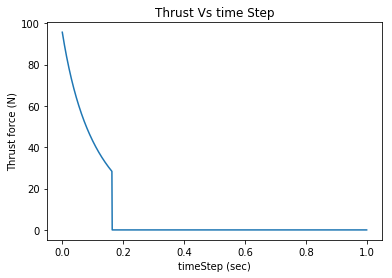

In [333]:
# now we approximate thrust force based on the assumption that it is zero after gas expand to
# the volume of water bottle, when there is no liquid left.

newF_thrust = [];
timeStep = [];

for i in range(0, 1001):
    if (i < np.size(Air_pressure_array)):
        pressureAtpoint = (M_G * 1000) * R * T_array[i] / (Molar_Gas * volume_Gas[i]);
        F_T_new = 2 * A_2 * (pressureAtpoint - P_atm) / (1 - np.power(A_2 / A_1, 2));
        newF_thrust.append(F_T_new);
        timeStep.append(i * dt);
    else:
        newF_thrust.append(0);
        timeStep.append(i * dt);
        
newF_thrust = np.array(newF_thrust);
timeStep = np.array(timeStep);
plt.xlabel("timeStep (sec)");
plt.ylabel("Thrust force (N)");
plt.title("Thrust Vs time Step");
plt.plot(timeStep, newF_thrust);

#Notice that we might have a jump discontinuity due to the fact that liquid has been evacuated from the chamber.
# As abnormal as it looks, due to small mass of the air, this is not a bas approximation, and discontinuity
# is something we need to thing about during the modeling.
# the part before thrust force equals to zero is almost identity (there is always numerical error in using euler's method, it
# is an approximation after all), with another thrust force graph we obtained above,
# this makes sense due to that we model our rocket using idea gas law.